# Network Analysis on Auckland road data
### Import packages

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools

### Importing territorial boundry of Auckland region

In [14]:
auckland_path = "data/geographic/territorial/auckland_polygon_diy.gpkg"
auckland = gpd.read_file(auckland_path)
auckland = auckland.to_crs(crs=4326)
polygonauck = auckland.iloc[0]['geometry']

In [15]:
waiheke_path = "data/geographic/territorial/waiheke_polygon.gpkg"
waiheke = gpd.read_file(waiheke_path)
waiheke = waiheke.to_crs(crs=4326)
polygonwaiheke = waiheke.iloc[0]['geometry']

### Generating the road network

In [16]:
Gdrive_auck = ox.graph.graph_from_polygon(polygonauck, network_type="walk", simplify = False)

In [17]:
Gdrive_waiheke = ox.graph.graph_from_polygon(polygonwaiheke, network_type="walk", simplify = False)
print("created")
Gdrive_waiheke = ox.add_edge_speeds(Gdrive_waiheke)
Gdrive_waiheke = ox.add_edge_travel_times(Gdrive_waiheke)
print("added all")

created
added all


In [18]:
# Add speed and travel time
Gdrive_auck = ox.add_edge_speeds(Gdrive_auck)
Gdrive_auck = ox.add_edge_travel_times(Gdrive_auck)
print("added all")
Auckland_waiheke_walk = nx.compose(Gdrive_auck,Gdrive_waiheke)
ox.io.save_graphml(Auckland_waiheke_walk, "data/network_analysis/auckland_waiheke_network_walk.graphml")

added all


In [2]:
G = ox.io.load_graphml("data/network_analysis/auckland_waiheke_network_walk.graphml")

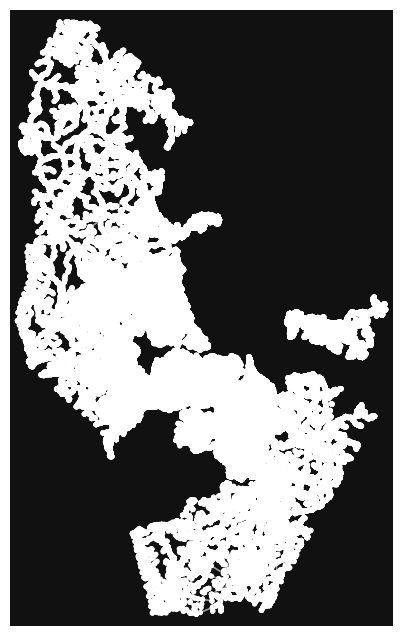

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [3]:
ox.plot.plot_graph(G)

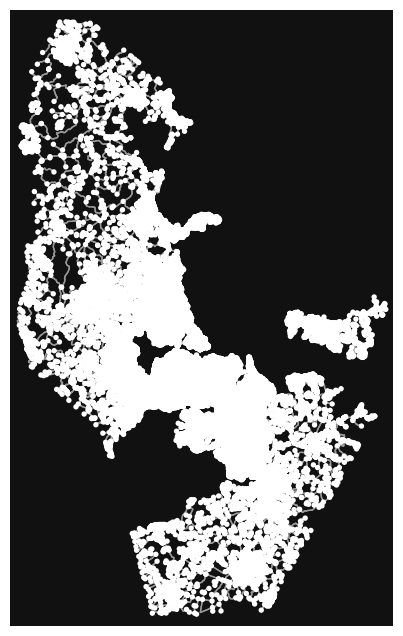

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [4]:
G_consolifull = ox.simplification.simplify_graph(G, strict=True)
ox.plot.plot_graph(G_consolifull)


Save for future use

In [5]:
ox.io.save_graph_geopackage(G_consolifull, "data/network_analysis/full_auckland_waiheke_walk_simplified.gpkg")

In [15]:
ox.io.save_graphml(G, filepath="data/network_analysis/auckland_network_bike_unconsolidated.graphml", gephi=False, encoding='utf-8')

### Consolidate the newtork to solve the spatial/topological issue

In [11]:
G_consoli = ox.simplification.consolidate_intersections(G, rebuild_graph=False)

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:405: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid


In [3]:
# get the nodes and the edges into geopandas
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Adding other data
### Import the grid of urban Auckland including census variables
The IDW was done in R. Code in the file data-prep.R

<AxesSubplot: >

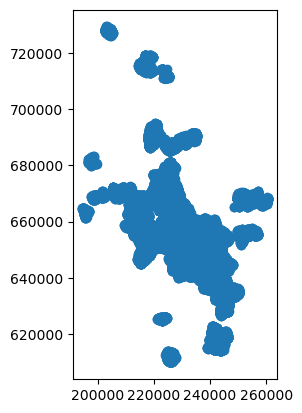

In [13]:
grid = gpd.read_file("data/geographic/grids/grid_50000_auckland_census.gpkg")
grid['lon'] = grid['geometry'].x
grid['lat'] = grid['geometry'].y
grid.plot()

### Snap the grid of points to the nearest road egde
This is so that I can later calculate network distances between each point to the supply points

In [14]:
grid[["ne_u","ne_v","ne_dist"]] = ox.distance.nearest_edges(G, X=grid["lon"], Y=grid["lat"])
grid.head()

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))


,income,no_households,maori_pr,dampness,geometry,lon,lat,ne_u,ne_v,ne_dist
0,36710.691419,50.796403,0.201352,127.790087,POINT (225532.509 609808.736),225532.509406,609808.736016,4702583893,1248955003,0
1,36882.949283,50.309440,0.198384,126.097575,POINT (225657.352 609808.736),225657.352287,609808.736016,4702583893,1248955003,0
2,37549.885003,48.335262,0.197472,124.746673,POINT (225782.195 609808.736),225782.195169,609808.736016,4702583893,1248955003,0
3,38054.679447,47.356256,0.189796,117.682066,POINT (225907.038 609808.736),225907.038050,609808.736016,4702583893,1248955003,0
4,38253.993943,47.114833,0.185706,115.530078,POINT (226031.881 609808.736),226031.880931,609808.736016,4702583893,1248955003,0


Save the grid with nearest edge for future use

In [125]:
grid.to_file("data/geographic/grids/grid_50000_auckland_census.gpkg", layer='grid', driver="GPKG")

### Import the train stations in Auckland
The IDW was done in R. Code in the file data-prep.R

<AxesSubplot: >

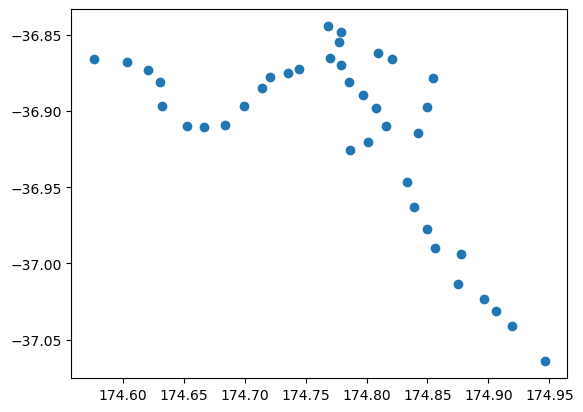

In [104]:
stations = gpd.read_file("data/transport/public_transport/trains_auckland.gpkg")
stations['lon'] = stations['geometry'].x
stations['lat'] = stations['geometry'].y
stations.plot()

### Snap the train station points to the nearest road egde
This is for later calculation of network distances between each station to the demand points - grid

In [105]:
stations[["u", "v", "dist"]] = ox.distance.nearest_edges(G, X=stations["lon"], Y=stations["lat"])
stations.head()

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))


,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTYPE,STOPLAT,STOPLON,PARENTSTATION,MODE,geometry,lon,lat,u,v,dist
0,1,97,97,Papakura Train Station,None,Stop,-37.064294,174.946114,None,Train,POINT (174.94611 -37.06429),174.946114,-37.064294,1071743678,5882816768,0
1,2,98,98,Manurewa Train Station,None,Stop,-37.023268,174.896171,None,Train,POINT (174.89617 -37.02327),174.896171,-37.023268,3843898501,7870811398,0
2,3,125,125,Henderson Train Station,None,Stop,-36.880965,174.630910,None,Train,POINT (174.63091 -36.88097),174.630910,-36.880965,8323389695,711693102,0
3,4,127,127,Swanson Train Station,None,Stop,-36.866181,174.576300,None,Train,POINT (174.57630 -36.86618),174.576300,-36.866181,9393064946,3490204785,0
4,5,113,113,Greenlane Train Station,None,Stop,-36.889657,174.797419,None,Train,POINT (174.79742 -36.88966),174.797419,-36.889657,26010886,26010873,0


In [107]:
stations.to_file("data/transport/public_transport/trains_auckland_with_distances_on_network.gpkg", layer='grid', driver="GPKG")

# Bus Freqnecy from GTSF

In [1]:
df = pd.read_csv("data/transport/GTFS/gtfs_auckland/stop_times.txt",sep=",", encoding="gbk")
df.drop(columns=df.columns[-4:], axis=1,  inplace=True)

NameError: name 'pd' is not defined

In [ ]:
# sum bus departures from bus stops per day
df2 = df.groupby(by='stop_id').count().sort_values(by='arrival_time',ascending=False)

df2['busDepsPerHour'] = df2['departure_time']/24 # get average buses per hour
df2 = df2.loc[df2['busDepsPerHour'] >= 6] #select bus stops with more than 6 buses per hour, approximation of buses every 10 minutes

df2.to_csv("bus_frequency.csv") #save, joining with spatial bus stops was done in QGIS